# Imports and Setup

In [185]:
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import pandas as pd
import random
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import optproblems.cec2005 as opt
import optproblems.base as base

# Helper Functions

In [186]:
def show_func(func, range):
    x, y = np.array(np.meshgrid(np.linspace(range[0],range[1],100), np.linspace(range[0],range[1],100)))
    z = func([x, y])
    x_min = x.ravel()[z.argmin()]
    y_min = y.ravel()[z.argmin()]
    plt.figure(figsize=(8,6))
    plt.imshow(z, extent=[range[0], range[1], range[0], range[1]], origin='lower', cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
    plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    plt.show()

# Benchmark Functions

In [187]:
def rastrigin(input):
    result = 10*len(input)
    for x in input:
        result += x**2 - 10 * (np.cos(2 * np.pi * x))
    return result

def sphere(input):
    result = 0
    for x in input:
        result += x**2
    return result

def rosenbrock(input):
    result = 0
    for i in range(len(input) - 1):
        result += 100*(input[i+1] - input[i]**2)**2 + (1 - input[i])**2
    return result

def styblinski_tang(input):
    result = 0
    for x in input:
        result += x**4 - 16*x**2 + 5*x
    return result/2

# Particle Swarm Optimisation Algorithm

### Particle Class

In [188]:
class Particle:
    def __init__(self, numInputs, domain, func, weights):
        self.position = []
        self.velocity = []
        self.bestPos = []
        self.informants: list[Particle] = []
        self.func = func
        self.domain = domain
        self.dimensions = numInputs
        self.weights = weights

        for i in range(numInputs):
            self.position.append(random.uniform(domain[0], domain[1]))
            self.velocity.append(random.uniform(-1, 1))
 
        self.result = self.func(self.position)
        self.bestResult = self.result
        self.bestPos = self.position
    
    def evaluate(self):
        self.result = self.func(self.position)

        if self.result < self.bestResult:
            self.bestResult = self.result
            self.bestPos = self.position

    def update_velocity(self, globalBestPos):
        bestInformant = self.informants[0]
        for particle in self.informants:
            if particle.bestResult < bestInformant.bestResult:
                bestInformant = particle

        for i in range(self.dimensions):
            cognitive = random.uniform(0, self.weights[1])*(self.bestPos[i] - self.position[i])
            social = random.uniform(0, self.weights[2])*(bestInformant.bestPos[i] - self.position[i])
            globalv = random.uniform(0, self.weights[3])*(globalBestPos[i] - self.position[i])
            self.velocity[i] = self.weights[0]*self.velocity[i] + cognitive + social + globalv
    
    def update_position(self):
        for i in range(self.dimensions):
            self.position[i] += self.weights[4] * self.velocity[i]
            
            if self.position[i] < self.domain[0]:
                self.position[i] = self.domain[0]
            elif self.position[i] > self.domain[1]:
                self.position[i] = self.domain[1]

### Particle Swarm Optimization Algorithm Class

In [189]:
class PSO():
    def __init__(self, numInputs, domain, func, weights, swarmSize, numInformants, maxIter):
        self.swarm: list[Particle] = []
        self.swarmSize = swarmSize
        self.maxIter = maxIter

        for i in range(swarmSize):
            self.swarm.append(Particle(numInputs, domain, func, weights))
        
        for i in range(swarmSize):
            for j in range(numInformants):
                self.swarm[i].informants.append(random.choice(self.swarm))

    def optimize(self):
        i = 0
        globalBest = self.swarm[0]
        while i < self.maxIter:
            for j in range(self.swarmSize):
                self.swarm[j].evaluate()
            
            for j in range(self.swarmSize):
                if self.swarm[j].bestResult < globalBest.bestResult:
                    globalBest = self.swarm[j]

            for j in range(self.swarmSize):
                self.swarm[j].update_velocity(globalBest.bestPos)
                self.swarm[j].update_position()

            i+=1

        print("Solution:")
        print(globalBest.bestPos)
        print("Result:")
        print(globalBest.bestResult)


# Runnning and Testing

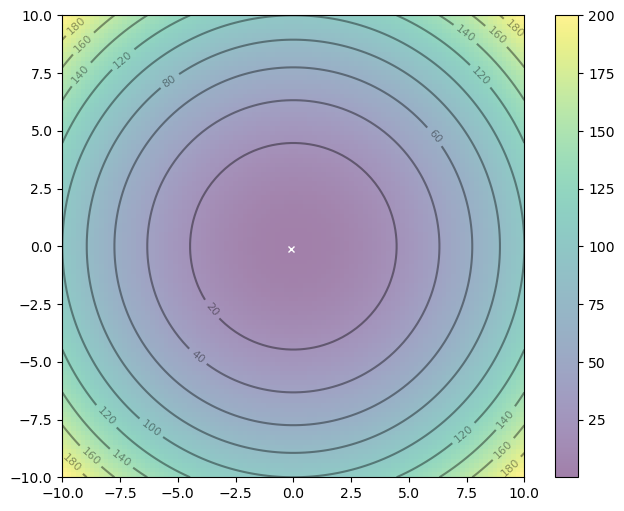

Solution:
[-0.3354874120934366, -0.4571907989253732, -0.2274421668076122, 0.20543918524716948, 0.35312589558549373, 0.07639081199212389, -0.2736740451862543, -0.08558744168297287, 0.09410171759828247, -0.043778191644093724]
Result:
0.6388050173193024


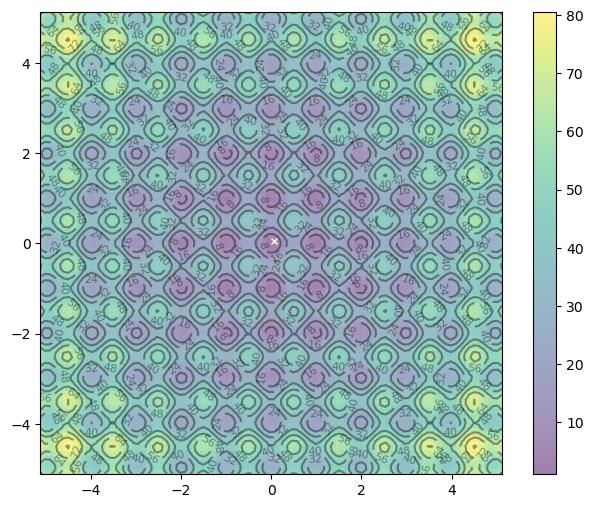

Solution:
[-0.05567097336232302, 0.6778426074396172, 0.46136770391900106, -0.1674196320018422, -0.8394632205130359, 0.6485386583299658, 0.5225250797871909, 0.7898696630043811, 0.32372114122546874, -0.15133815570969844]
Result:
43.71490611234339


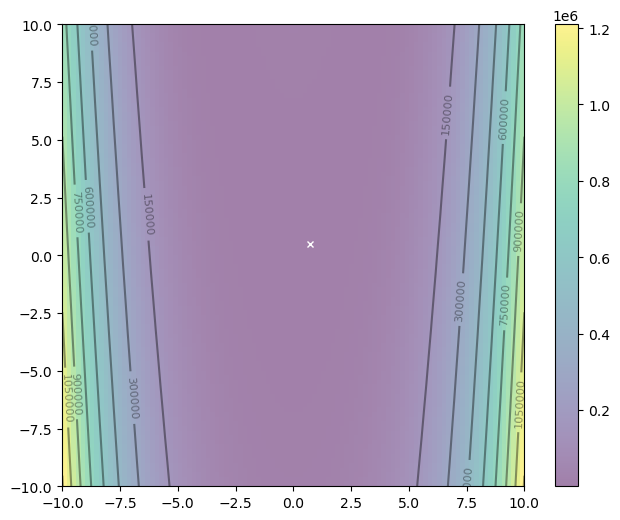

Solution:
[0.6120696025840369, 0.28608564473718373, 0.6013725519256374, 0.2705219451280209, -0.19441216463502298, 0.2222639255872522, 0.14142425370634584, 0.20978829517895842, 0.8389841860617365, 1.238296050409092]
Result:
138.97365090719785


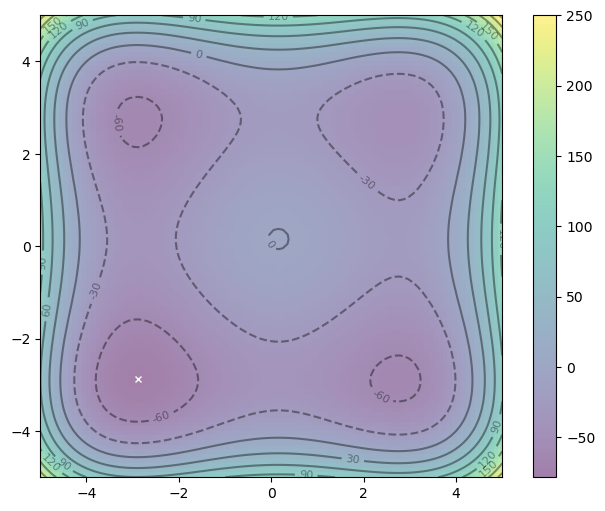

Solution:
[0.01781928765363621, -2.243801351389193, -2.7665989591151785, -0.941271575026458, -1.3207792032794228, -1.3657680706743487, -1.3694969527674763, -2.397199650943303, -1.843157462876285, -0.6368708970578855]
Result:
-274.3920090819983


In [190]:
show_func(sphere, [-10, 10])
PSO(10, [-10, 10], sphere, [0.5, 1, 1, 0.5, 0.1], 100, 10, 1000).optimize()

show_func(rastrigin, [-5.12, 5.12])
PSO(10, [-5.12, 5.12], rastrigin, [0.5, 1, 1, 0.5, 0.1], 100, 10, 1000).optimize()

show_func(rosenbrock, [-10, 10])
PSO(10, [-10, 10], rosenbrock, [0.5, 1, 1, 0.5, 0.1], 100, 10, 1000).optimize()

show_func(styblinski_tang, [-5, 5])
PSO(10, [-5, 5], styblinski_tang, [0.5, 1, 1, 0.5, 0.1], 100, 10, 1000).optimize()